# Long notebook for group 16

> Group 16 : Laure Beringer, Hasse Rombouts, Henrik Fjellheim

In this notebook we will present all important experiments we've tried for the project of the TDT4173 Machine Learning course.  
The notebook will present the following:
1. [EDA](#eda)
2. [Feature Engineering](#featureEngineering)
2. [Models](#models)
3. [Ensemble of models](#ensemble-of-models)


Imports and main commun functions:

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from scipy import stats
import json
import seaborn as sns

import plotly.express as px
import matplotlib.pylab as plt
plt.style.use('ggplot')

def root_mean_squared_log_error(y_true, y_pred):
    # Alternatively: sklearn.metrics.mean_squared_log_error(y_true, y_pred) ** 0.5
    assert (y_true >= 0).all() 
    assert (y_pred >= 0).all()
    log_error = np.log1p(y_pred) - np.log1p(y_true)  # Note: log1p(x) = log(1 + x)
    return np.mean(log_error ** 2) ** 0.5

## EDA

This part will contain :
1. [Load and describe the data](#loading-and-description-of-the-data)
2. [Further investigation and data cleaning]()
3. [Missing values](#missing-values)
4. [Feature engineering](#feature-engineering)

### Loading and description of the data

#### Loading

Loading and merging of the data:

In [6]:
# Reading the datasets
# Metadata
metaData_apartment = pd.read_json('data/apartments_meta.json')
metaData_building = pd.read_json('data/buildings_meta.json')
metaData = pd.concat([metaData_apartment, metaData_building])

# train
train_apartment = pd.read_csv('data/apartments_train.csv')
train_building = pd.read_csv('data/buildings_train.csv')
df_train = pd.merge(train_apartment, train_building, left_on='building_id', right_on='id')
df_train.rename(columns={'id_x' : 'apartment_id'}, inplace=True)
df_train.drop('id_y', axis=1, inplace=True)

# test
test_apartment = pd.read_csv('data/apartments_test.csv')
test_building = pd.read_csv('data/buildings_test.csv')
df_test = pd.merge(test_apartment, test_building, left_on='building_id', right_on='id')
df_test.rename(columns={'id_x' : 'apartment_id'}, inplace=True)
df_test.drop('id_y', axis=1, inplace=True)

df_all = pd.concat([df_train, df_test])

Some basic information about the data:

In [4]:
print('Number of Training Examples = {}'.format(df_train.shape[0]))
print('Number of Test Examples = {}\n'.format(df_test.shape[0]))
print('Training X Shape = {}'.format(df_train.shape))
print('Training y Shape = {}\n'.format(df_train['price'].shape[0]))
print('Test X Shape = {}'.format(df_test.shape))
print('Test y Shape = {}\n'.format(df_test.shape[0]))
print('Train columns \n', list(df_train.columns))
print('Test columns \n', list(df_test.columns))

Number of Training Examples = 23285
Number of Test Examples = 9937

Training X Shape = (23285, 34)
Training y Shape = 23285

Test X Shape = (9937, 33)
Test y Shape = 9937

Train columns 
 ['apartment_id', 'seller', 'price', 'area_total', 'area_kitchen', 'area_living', 'floor', 'rooms', 'layout', 'ceiling', 'bathrooms_shared', 'bathrooms_private', 'windows_court', 'windows_street', 'balconies', 'loggias', 'condition', 'phones', 'building_id', 'new', 'latitude', 'longitude', 'district', 'street', 'address', 'constructed', 'material', 'stories', 'elevator_without', 'elevator_passenger', 'elevator_service', 'parking', 'garbage_chute', 'heating']
Test columns 
 ['apartment_id', 'seller', 'area_total', 'area_kitchen', 'area_living', 'floor', 'rooms', 'layout', 'ceiling', 'bathrooms_shared', 'bathrooms_private', 'windows_court', 'windows_street', 'balconies', 'loggias', 'condition', 'phones', 'building_id', 'new', 'latitude', 'longitude', 'district', 'street', 'address', 'constructed', 'mater

#### Description

Functions to describe each colmuns of the data using the metadata:

In [5]:
def describe_column(meta):
    """
    Utility function for describing a dataset column (see below for usage)
    """
    def f(x):
        d = pd.Series(name=x.name, dtype=object)
        m = next(m for m in meta if m['name'] == x.name)
        d['Type'] = m['type']
        d['#NaN'] = x.isna().sum()
        d['Description'] = m['desc']
        if m['type'] == 'categorical':
            counts = x.dropna().map(dict(enumerate(m['cats']))).value_counts().sort_index()
            d['Statistics'] = ', '.join(f'{c}({n})' for c, n in counts.items())
        elif m['type'] == 'real' or m['type'] == 'integer':
            stats = x.dropna().agg(['mean', 'std', 'min', 'max'])
            d['Statistics'] = ', '.join(f'{s}={v :.1f}' for s, v in stats.items())
        elif m['type'] == 'boolean':
            counts = x.dropna().astype(bool).value_counts().sort_index()
            d['Statistics'] = ', '.join(f'{c}({n})' for c, n in counts.items())
        else:
            d['Statistics'] = f'#unique={x.nunique()}'
        return d
    return f

def describe_data(data, meta):
    desc = data.apply(describe_column(meta)).T
    desc = desc.style.set_properties(**{'text-align': 'left'})
    desc = desc.set_table_styles([ dict(selector='th', props=[('text-align', 'left')])])
    return desc 

Description of the apartment data:

In [6]:
print(f'Loaded {len(train_apartment)} apartments')
# metadata as json
with open('data/apartments_meta.json') as f: 
    apartments_meta = json.load(f)
describe_data(train_apartment, apartments_meta)

Loaded 23285 apartments


,Type,#NaN,Description,Statistics
id,integer_id,0,Unique ID for apartment,#unique=23285
seller,categorical,8830,The type of apartment seller,"Agents(1895), Company(4768), Developer(6185), Owner(1607)"
price,real,0,The listed price of the apartment (TARGET),"mean=23556173.5, std=52643927.8, min=900000.0, max=2600000000.0"
area_total,real,0,Total area of the apartment,"mean=74.5, std=58.7, min=9.3, max=2181.0"
area_kitchen,real,4721,Total kitchen area in the apartment,"mean=12.6, std=6.6, min=1.0, max=100.0"
area_living,real,3882,Total living space area in the apartment,"mean=38.7, std=31.4, min=0.0, max=900.0"
floor,integer,0,Primary building floor of the apartment,"mean=9.0, std=8.3, min=1.0, max=95.0"
rooms,integer,0,Number of rooms in the apartment,"mean=2.2, std=1.1, min=1.0, max=6.0"
layout,categorical,17642,Overal apartment layout,"Adjacent(241), Adjacent_isolated(465), Isolated(4937)"
ceiling,real,11093,Ceiling height in the apartment,"mean=3.3, std=10.8, min=0.0, max=340.0"


We can see that the features with no nan values are : id, price, area_total, floor, rooms and building_id.  
The categorical features of the apartments are : seller, layout and condition.

Description of the building data:

In [7]:
print(f'Loaded {len(train_building)} building')
# metadata as json
with open('data/buildings_meta.json') as f: 
    building_meta = json.load(f)
describe_data(train_building, building_meta)

Loaded 6791 building


,Type,#NaN,Description,Statistics
id,integer_id,0,Unique ID of building for joining with apartments,#unique=6791
new,boolean,227,Whether it is an old or new building,"False(6141), True(423)"
latitude,real,0,Latitude coordinate of building,"mean=55.7, std=0.1, min=55.2, max=56.0"
longitude,real,0,Longitude coordinate of building,"mean=37.6, std=0.2, min=36.9, max=38.0"
district,categorical,1,Administriative district within Moscow,"Central(637), East(956), North(593), North-East(630), North-West(553), Novomoskovsk(344), South(758), South-East(672), South-West(900), Troitsk(146), West(535), Zelenograd(66)"
street,string,0,Bulding street name,#unique=1682
address,string,0,Building address (within street),#unique=1851
constructed,integer,479,Year when the building was constructed,"mean=1985.8, std=24.3, min=1855.0, max=2023.0"
material,categorical,1165,Primary building material used in building,"Block(679), Bricks(1226), Monolith(1312), Monolithic_brick(19), Panel(2384), Stalin_project(2), Wood(4)"
stories,integer,0,Total number of floors in the building,"mean=13.0, std=7.0, min=1.0, max=95.0"


We can see that the features with no nan values are : id, latitude, longitude, street, address and stories.  
The categorical features of the building data are : district, material, parking and heating

#### First plots

##### Histograms to get an overview
Initially a the histogram of all features were plotted, giving an overview of the data and what to expect from the features. Some immediate points of concern where noted right away.

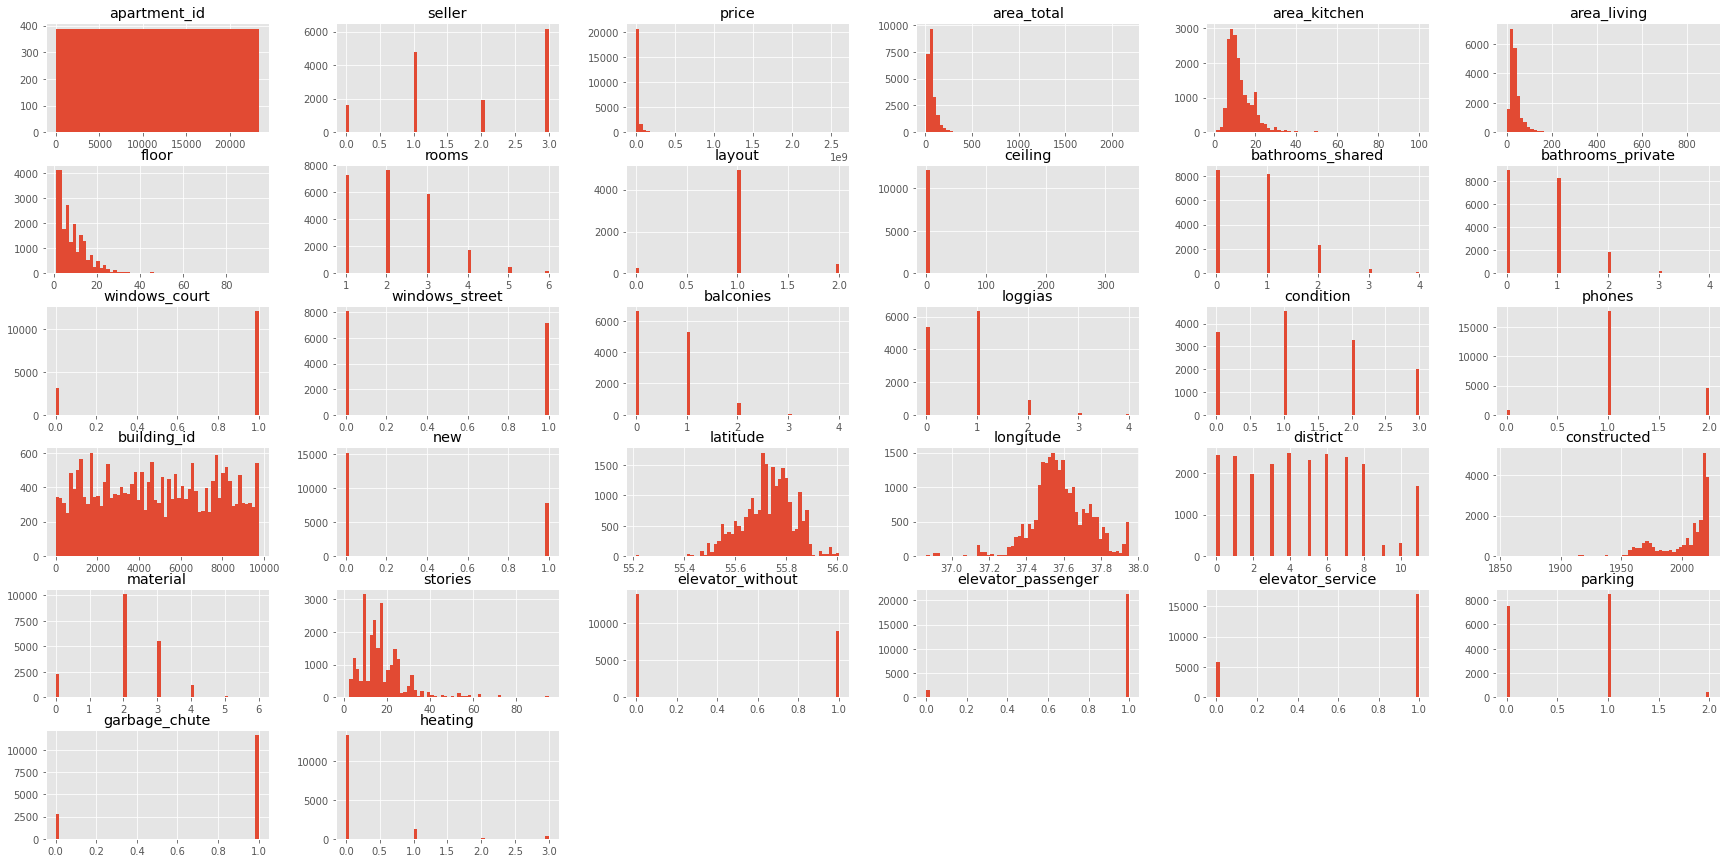

In [39]:
#df_train[["area_total", "area_living", "area_kitchen", "ceiling", "latitude", "longitude"]].hist(bins=60, figsize=(30,7))
df_train.hist(bins=60, figsize=(30,15))
plt.show()

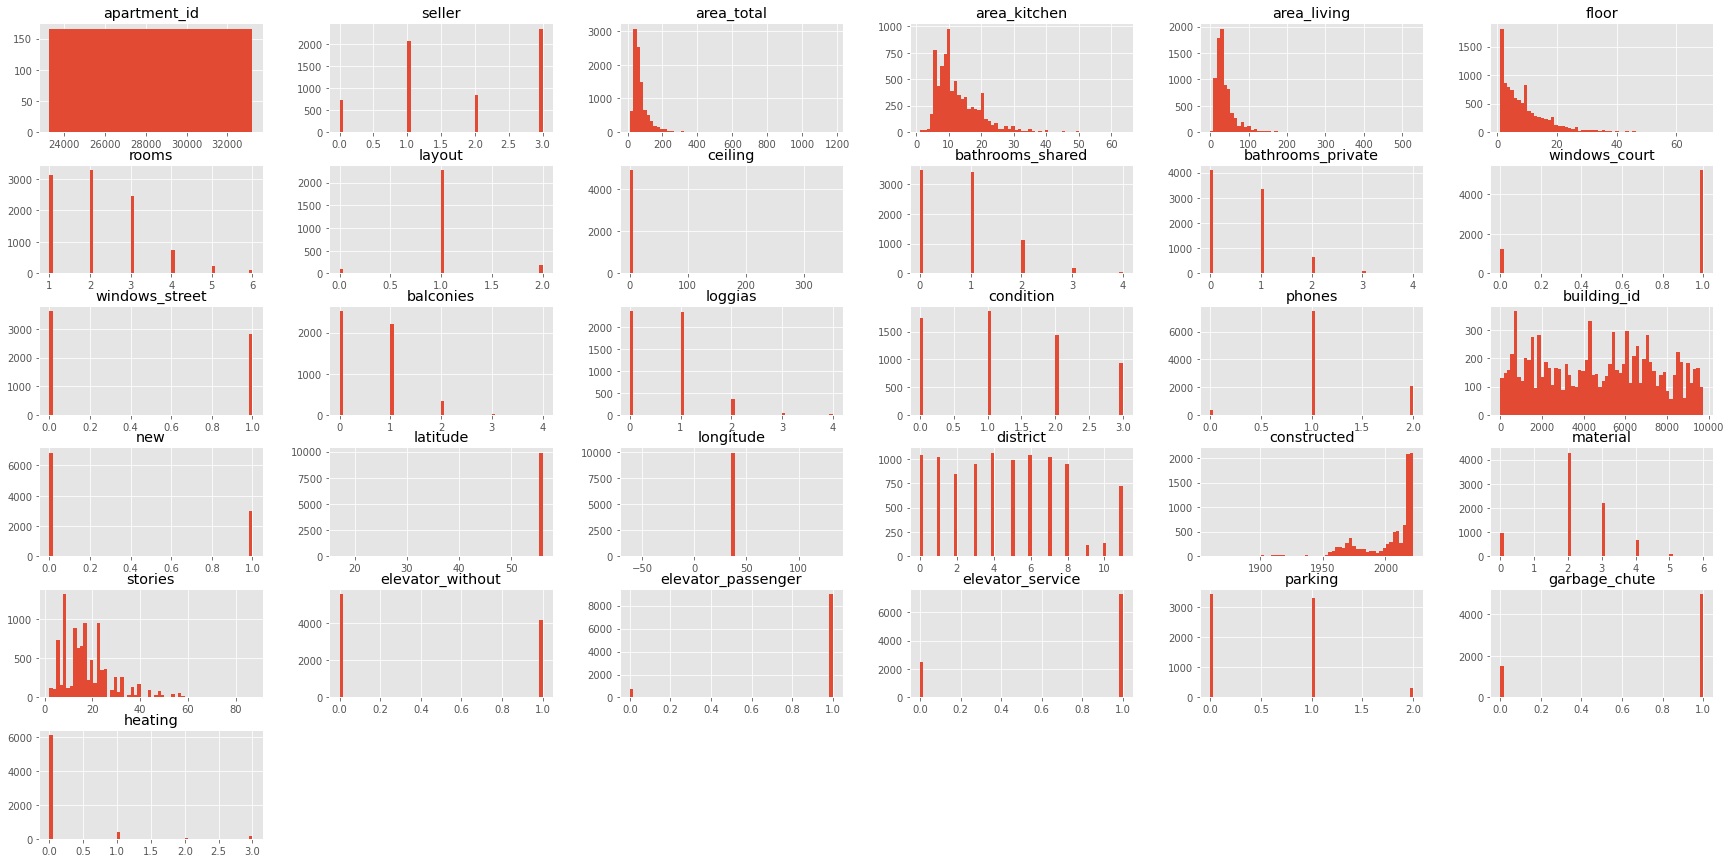

In [40]:
df_test.hist(bins=60, figsize=(30,15))
plt.show()

#### Immediate notes of concern
- Area-data seems to contain some outlayers, probably some huge luxury villas, which heavily skew the histogram.
- Ceiling data for both training and testing data has some super-wide outlayers. This might be possible to explain, or it could be wrong data.
- While longitude and lattitude seems to have a gaussian distribution for train data, in the testing data there seems to be something off

##### Looking at nan-distributions
In addition to histograms, looking at the nan percentages of each features is a good place to start. We see that many features has above 50% nan rate, and we have to be creative if we are to use these effectively. 

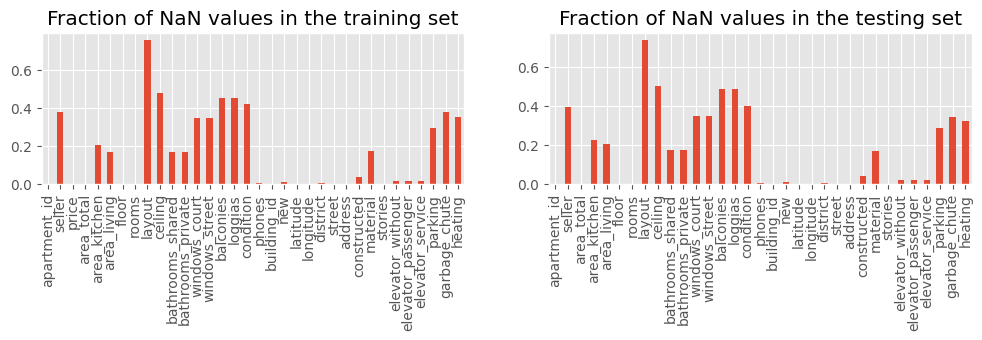

In [43]:
fig, (ax1, ax2) = plt.subplots(figsize=(12, 2), ncols=2, dpi=100)
df_train.isna().mean().plot.bar(ax=ax1, title='Fraction of NaN values in the training set')
df_test.isna().mean().plot.bar(ax=ax2, title='Fraction of NaN values in the testing set');

### Further investigation and data cleaning

#### Price distribution
The price distribution in training data contains a lot of outlayers, as for the area data, skewing the graph heavily.
We know that an "Root mean squared log error" function is going to be used for the loss of this competition, so missing some of the outlayers in our prediction wont be that impactful on our score. What we can do at our end is to log the target, price.

In [36]:
train_targets = np.log(df_train["price"])

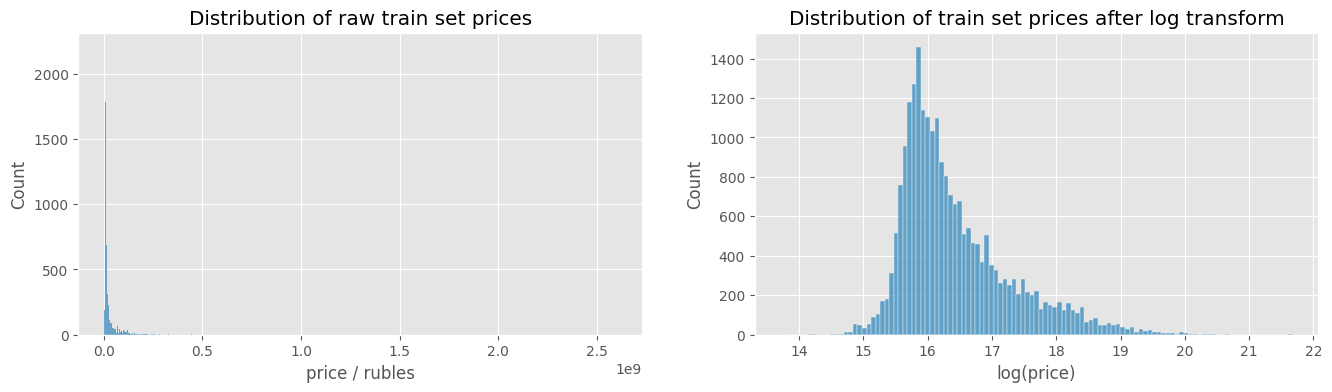

In [44]:
fig, (ax1, ax2) = plt.subplots(figsize=(16, 4), ncols=2, dpi=100)
sns.histplot(df_train.price.rename('price / rubles'), ax=ax1)
ax1.set_title('Distribution of raw train set prices')
sns.histplot(np.log(df_train.price).rename('log(price)'), ax=ax2)
ax2.set_title('Distribution of train set prices after log transform');

#### Apartments position and price
Taking a closer look at the longitude and lattitude data. There are obviously some apartments of the testing data, not positioned placed in moscow at all. We will not be able to drop them from the dataset, but we will see if we can do something about them.

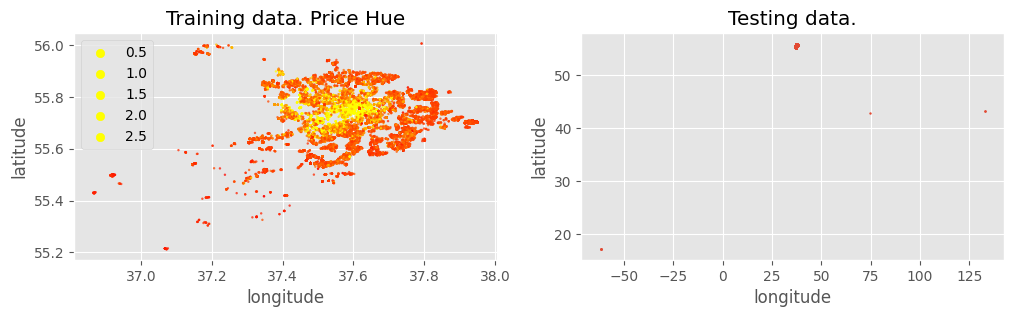

In [45]:
fig, (ax1, ax2) = plt.subplots(figsize=(12, 3), ncols=2, dpi=100)
lo, hi = df_train["price"].quantile([0.0, 0.8])
hue_norm = plt.Normalize(lo, hi)
hue = df_train["price"].tolist()

ax1.set_title("Training data. Price Hue")
ax2.set_title("Testing data.")
sns.scatterplot(x='longitude', y='latitude', ax=ax1, hue=hue, alpha=0.75, s=3, palette="autumn", linewidth=0, hue_norm=hue_norm, data=df_train[['latitude', 'longitude']])
sns.scatterplot(x='longitude', y='latitude', ax=ax2, alpha=1, s=3, palette="autumn", linewidth=0, data=df_test[['latitude', 'longitude']]);

Lets start by seeing how many apartments we have to deal with.

### Missing values

Training set features with any missing value: 23/34
Testing set features with any missing value: 25/33
Features with no missing values: ['apartment_id', 'price', 'area_total', 'floor', 'rooms', 'building_id', 'latitude', 'longitude', 'street', 'address', 'stories']


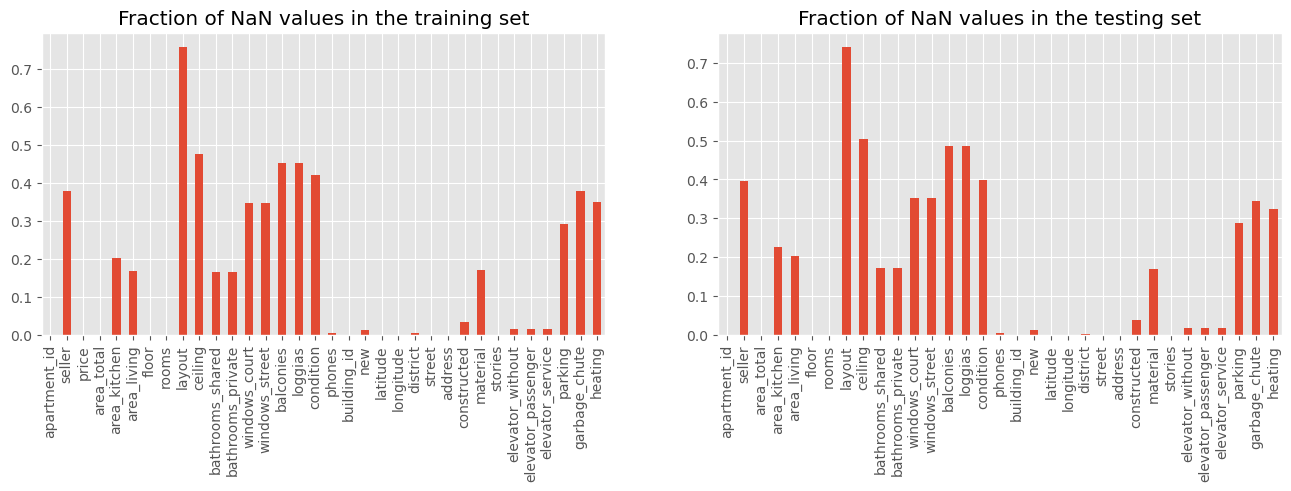

In [11]:
fig, (ax1, ax2) = plt.subplots(figsize=(16, 4), ncols=2, dpi=100)
print(f'Training set features with any missing value: {df_train.isna().any().sum()}/{df_train.shape[1]}')
print(f'Testing set features with any missing value: {df_test.isna().any().sum()}/{df_test.shape[1]}')
df_train.isna().mean().plot.bar(ax=ax1, title='Fraction of NaN values in the training set')
df_test.isna().mean().plot.bar(ax=ax2, title='Fraction of NaN values in the testing set');

featuresNA = dict(df_train.isna().any())
featuresNoNA = []
for key in featuresNA.keys():
    if not featuresNA[key] : featuresNoNA.append(key)
print('Features with no missing values:', featuresNoNA)

#### Area_living

C:\Users\Laure\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


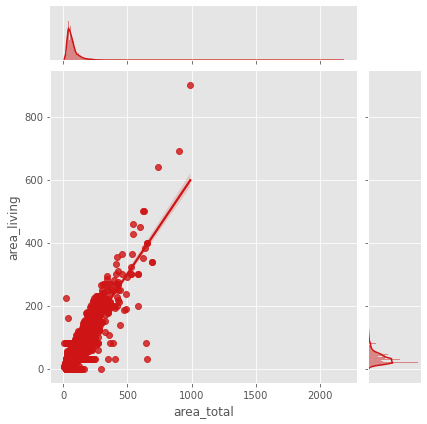

In [12]:
sns.jointplot(df_train.loc[:,'area_total'], df_train.loc[:,'area_living'], kind="reg", color="#ce1414")

There is a clear link between area_total and area_living is very clear. So we can use area_total to complete area_living.

#### Area_kitchen

In [13]:
fig = px.scatter_3d(df_train, x='area_kitchen', y='area_total', z='area_living',
              color='area_kitchen')
fig.show()

We can clearly see a plane between those three features. We can then deduce the missing values of the feature area_kitchen with the values of the features area_total and area_living.

#### Other missing values

For the rest of the missing values, we decided to use the mean to fill the float numerical features and to use the median for all the other types of features.

In [ ]:
float_numerical_features = ["area_total", "area_kitchen", "area_living", "ceiling", "latitude", "longitude", "constructed"]
int_numerical_features = ["floor", "stories", "rooms", "bathrooms_private", "bathrooms_shared", "balconies", "loggias", "phones"] # Ordinal categories
cat_features = ["layout", "condition", "district", "material", "parking", "heating", "seller"] # All are non-ordinal

# Float
df_train[float_numerical_features] = df_train[float_numerical_features].fillna(df_train[float_numerical_features].mean())
# Int
df_train[int_numerical_features] = df_train[int_numerical_features].fillna(df_train[int_numerical_features].median())
# Cat
df_train[cat_features] = df_train[cat_features].fillna(df_train[cat_features].median())
# Bool (The rest)
df_train = df_train.fillna(df_train.median()) # Boolean

### Outliers removal

### Feature engineering

#### Feature Correlation

Text(0.5, 1.0, 'Correlations all data')

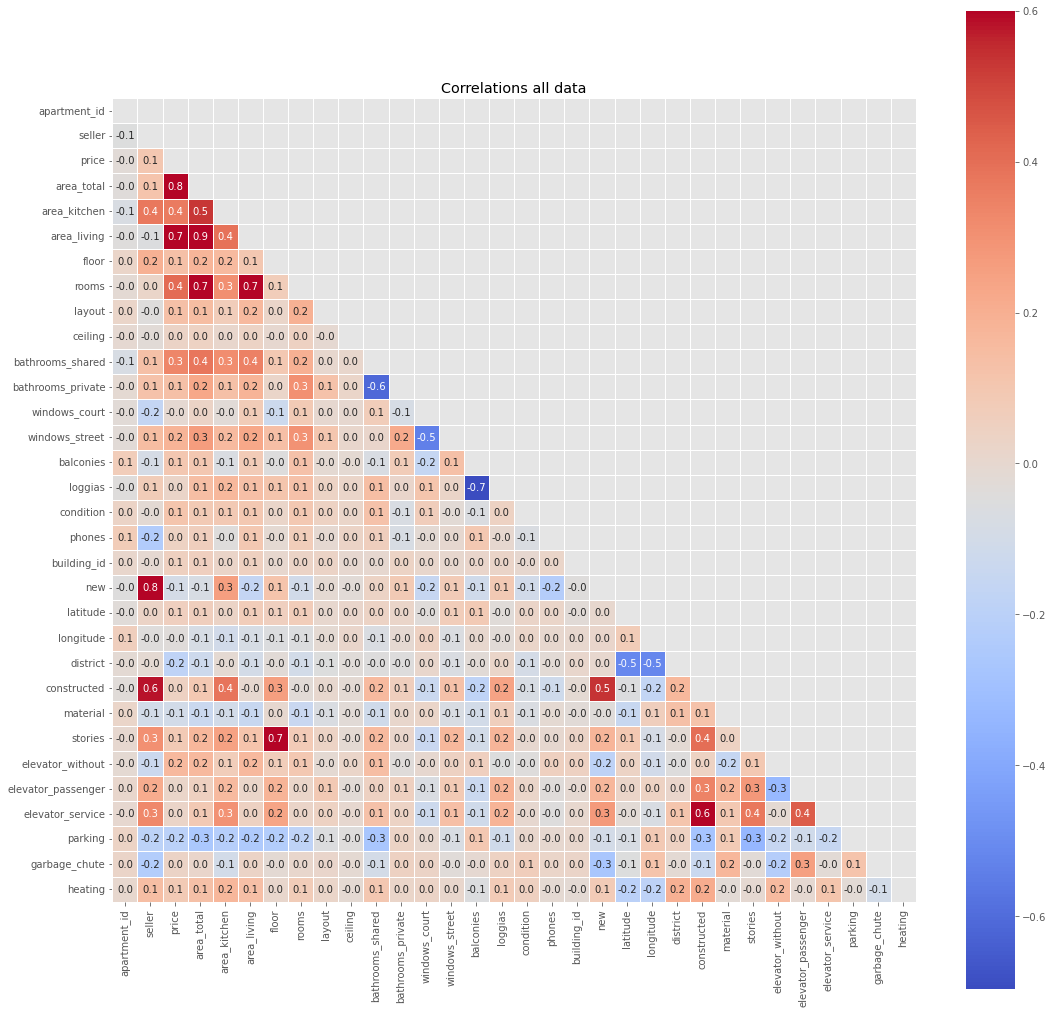

In [14]:
corr = df_train.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

f,ax = plt.subplots(figsize=(18, 18))
sns.heatmap(df_train.corr(), mask=mask, vmax=0.6, square=True, cmap='coolwarm', annot=True, linewidths=.5, fmt= '.1f',ax=ax)
plt.title('Correlations all data')

Text(0.5, 1.0, 'Features Correlating with price')

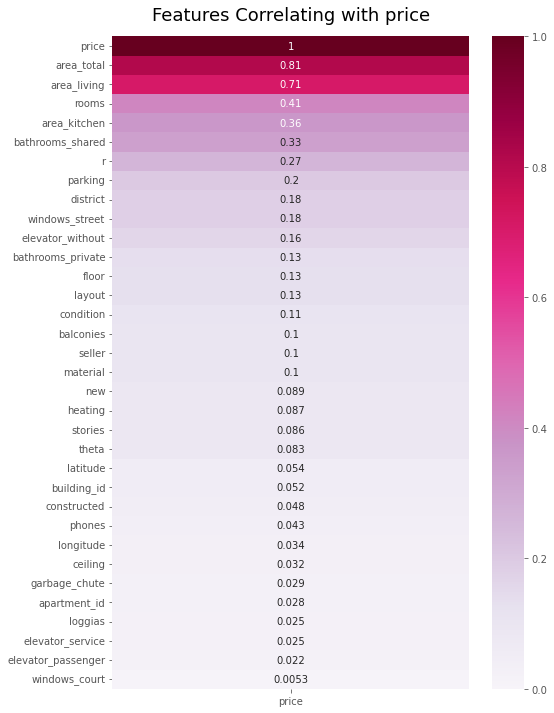

In [27]:
plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(abs(df_train.corr()[['price']]).sort_values(by='price', ascending=False), vmin=0, vmax=1, annot=True, cmap='PuRd')
heatmap.set_title('Features Correlating with price', fontdict={'fontsize':18}, pad=16)

The features area_total and rooms have no missing values and correlate strongly with the price. These will be the main features. (area_living and area_kitchen are very correlated to area_total so they may not be very useful)

#### New features

##### R and Theta

Since the city of Moscow is pretty close to a center and the most expensive apartments are in the center, we though it would be more representative to use r and theta (radius and angle) for the apartment position instead of latitude and longitude. We also moved the origin of latitude and longitude to the mean.  
Those two new features are created as followed:

In [16]:
# Move origin to mean
df_train['latitude'] = df_train['latitude'] - df_train['latitude'].mean()
df_train['longitude'] = df_train['longitude'] - df_train['longitude'].mean()
df_test['latitude'] = df_test['latitude'] -  df_test['latitude'].mean()
df_test['longitude'] = df_test['longitude'] -  df_test['longitude'].mean()

# Convert to polar coordinates
df_train['r'] =  np.sqrt(df_train['latitude']**2 + df_train['longitude']**2)
df_train['theta'] = np.arctan(df_train['longitude']/df_train['latitude'])
df_test['r'] =  np.sqrt(df_test['latitude']**2 + df_test['longitude']**2)
df_test['theta'] = np.arctan(df_test['longitude']/df_test['latitude'])

We can see that we get better corrllation with price using those features:

Text(0.5, 1.0, 'Features Correlating with price')

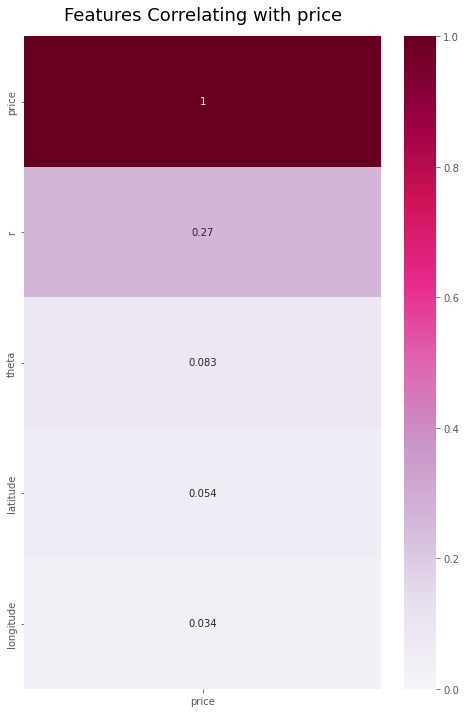

In [28]:
plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(abs(df_train[['latitude', 'longitude', 'r', 'theta', 'price']].corr()[['price']]).sort_values(by='price', ascending=False), vmin=0, vmax=1, annot=True, cmap='PuRd')
heatmap.set_title('Features Correlating with price', fontdict={'fontsize':18}, pad=16)

## Models

### Random forest

> Student: Laure Beringer  

I started using this model this the beginning of thsi project and used the class RandomForestRegressor from the library sklearn.  

For the hyperparameters, I ploted each one of them individually to get an estimated best version of the model. The parameter n_estimator was very pratical to have different computation times. The higher it was, the better the score was and the longer the model took. I kept the value 2000 so that the model would only take about 1min.  

This model did not benefit from scaling (the price), logging the price or feature and from one hot encoding, since categorical data is already well treated by this model.

For the preprocsessing, I only used the methods to fill the nan values.

In [ ]:
features = ["area_total", "latitude", "longitude", "floor", "district", "stories", 'condition']

model = RandomForestRegressor(
    n_estimators=2000,
    max_depth=400,
    min_samples_split=2,
    min_samples_leaf= 2,
    min_weight_fraction_leaf=0.00008,
    max_features='auto',
    max_leaf_nodes=None,
    min_impurity_decrease=1100,
    bootstrap=True,
    oob_score=False,
    n_jobs=None,
    random_state=None,
    verbose=0,
    warm_start=True,
    ccp_alpha=20000,
    max_samples=None
)

The best score on Kaggle ofr this model was around 0.2.

### K nearest neighbors

## Ensemble of models